# Cleaning

In [331]:
# Importing

import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

path = "../data/raw/houses_moreinfo.csv"

df = pd.read_csv(path)


In [332]:
df.head()

,id,city,postal_code,district,province,price,type_sale,subtype,sale_type,state_construction,...,swimmingpool,has_balcony,has_terrace,has_attic,has_basement,construction_year,epc,heating,life_annuity,area_total
0,1882546,Wenduine,8420,Oostend,West Flanders,163000.0,HOUSE,CHALET,FOR_SALE,AS_NEW,...,0,NaN,NaN,NaN,NaN,2023.0,NaN,GAS,0,155.0
1,2784938,Heist-aan-Zee,8301,Brugge,West Flanders,108000.0,HOUSE,BUNGALOW,FOR_SALE,AS_NEW,...,0,NaN,NaN,NaN,NaN,2023.0,NaN,GAS,0,170.0
2,4679861,Oostende,8400,Oostend,West Flanders,330000.0,HOUSE,HOUSE,FOR_SALE,GOOD,...,0,NaN,1.0,NaN,NaN,NaN,B,NaN,0,65.0
3,5650273,Dilsen-Stokkem,3650,Maaseik,Limburg,535000.0,HOUSE,APARTMENT_BLOCK,FOR_SALE,NaN,...,0,NaN,NaN,NaN,NaN,1988.0,B,GAS,0,0.0
4,6349237,Corswarem,4257,Waremme,Liège,NaN,HOUSE_GROUP,HOUSE_GROUP,FOR_SALE,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


In [333]:
# Change name of places to lower
def format_name(x):
    return x.lower()

df["city"] = df.city.apply(format_name)
df["district"] = df.district.apply(format_name)
df["province"] = df.province.apply(format_name)

# Substitute 0 for Nan
df.replace(0, np.nan, inplace=True)


In [334]:
# Drop rows with life_annuity == 1
life_annuity = df.query("life_annuity == 1").index

df.drop(life_annuity, inplace=True)
df.shape

(44908, 33)

In [335]:
# Drop where price is NaN
df.dropna(subset=['price'], inplace=True)

In [336]:
# Drop useless columns
df.drop(['life_annuity', 'has_balcony', "sale_type", "type_sale" ], axis=1, inplace=True)

In [337]:
# Drop castles
castles = df["subtype"] == "CASTLE"
df_clean = df[~castles]
df_clean.subtype.value_counts()

subtype
HOUSE                   32451
VILLA                    3864
APARTMENT_BLOCK          2306
MIXED_USE_BUILDING       1847
EXCEPTIONAL_PROPERTY      682
TOWN_HOUSE                506
MANSION                   499
BUNGALOW                  359
FARMHOUSE                 273
COUNTRY_COTTAGE           265
MANOR_HOUSE               178
CHALET                    120
OTHER_PROPERTY            112
Name: count, dtype: int64

# Start exploring

In [378]:
df_clean.shape

(43462, 29)

In [379]:
# Missing values
percent_missing = df_clean.isnull().sum() * 100 / len(df)
percent_missing

id                     0.000000
city                   0.000000
postal_code            0.000000
district               0.000000
province               0.000000
price                  0.000000
subtype                0.000000
state_construction    27.930702
living_area           14.576536
terrace_area          75.194155
garden_area           72.347319
rooms                 73.117044
bedrooms               2.522862
bathrooms             13.896420
livingroom_surface    61.010523
kitchen_surface       64.381232
facades               20.840035
has_garden            66.345756
kitchen               43.814622
furnished             98.614494
fireplace             80.885529
swimmingpool          96.946372
has_terrace           51.082211
has_attic             72.147420
has_basement          60.668168
construction_year     44.735996
epc                   19.629153
heating               32.475530
area_total            11.812417
dtype: float64

### Usefull functions

In [383]:
def IQR (column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    #quartiles = df[column].quantile([0.25, 0.75])
    iqr = Q3 - Q1
    lowerlimit = Q1 - 1.5*iqr
    upperlimit = Q3 + 1.5*iqr

    return lowerlimit, upperlimit

def thousants_point(x, n):
    return str('{:,}'.format(round(x), n).replace(',','.'))

### Usefull new columns

In [393]:
df_clean ["Price per Living Area"] = df_clean ["price"]/df_clean ["living_area"]
df_clean ["Price per Total Area"] = df_clean ["price"]/df_clean ["area_total"]


In [394]:
# Cleaning the price outliers via tukey IQR approach
lowerlimit, upperlimit  = IQR(df["price"])
price_no_outliers = df_clean[df_clean['price'].between(lowerlimit, upperlimit)]

# Define variables to be plotted together with graph
price_no_outliers_q1 = price_no_outliers["price"].quantile(0.25)
price_no_outliers_q3 = price_no_outliers["price"].quantile(0.75)
average_price_no_outliers = price_no_outliers.price.mean()


# Sets up texts to be displayed with the above variables
text_average = "Avg € " + thousants_point(average_price_no_outliers,0)
text_q1 = "Q1 € " + thousants_point(price_no_outliers_q1,0)
text_q3 = "Q3 € " + thousants_point(price_no_outliers_q3,0)


In [382]:

# Starts setting up histogram of prices
fig = px.histogram(price_no_outliers, x="price", nbins=40, labels={'price': "Price"}) 
fig.update_layout(bargap=0.2)

# Vertical lines that are added
fig.add_vline(x=average_price_no_outliers, line_dash = 'dash', line_color = 'firebrick', annotation_text= text_average, annotation_position="top")
fig.add_vline(x=price_no_outliers_q1, line_dash = 'dash', line_color = 'green', annotation_text= text_q1, annotation_position="top left")
fig.add_vline(x=price_no_outliers_q3, line_dash = 'dash', line_color = 'green', annotation_text= text_q3, annotation_position="top right")

# Making it a bit more pretty and clean
fig.update_layout(
    title = "Pricing distribution", 
    title_font=dict(size=20,
                    color='blue',
                    family='Arial'),
    title_x=0.1,  
)

# Display plot
fig.show()


In [392]:

# Subsetting dataframe for variables to be explored
price_area = price_no_outliers[["id", "price", "area_total", "living_area", "district"]]

# Calculates the price/ m2
price_area["Price per Living Area"] = price_area["price"]/price_area["living_area"]

# Cleans data from outliers via Tukey IQR method
lowerlimit, upperlimit  = IQR(price_area["Price per Living Area"])
price_area = price_area[price_area["Price per Living Area"].between(lowerlimit, upperlimit)]

# Set up info to be added to plot (average) and its text
average_price_living_area = price_area["Price per Living Area"].mean()
text_average_living = "Avg € " + thousants_point(average_price_living_area,0) + "/m²"

# Starts setting up the histogram
fig = px.histogram(price_area, x="Price per Living Area", nbins = 50, title="Number of houses versus price per m²", labels={"Price per Living Area": "Price per area (€ / m²)"}) 
fig.add_vline(x=average_price_living_area, line_dash = 'dash', line_color = 'firebrick', annotation_text= text_average_living, annotation_position="top")
fig.update_layout(bargap=0.2)

# Displays the plot
fig.show()

In [399]:
# Selecting only columns with EPC correctly inputed
mask_epc = price_no_outliers['epc'].isin(["A++", "A+", "A", "B", "C", "D", "E", "F", "G"])
compare_epc= price_no_outliers[mask_epc]

# Grouping interesting variables per EPC type
compare_epc = compare_epc.groupby('epc', as_index=False)[["Price per Living Area",'construction_year','Price per Total Area']].mean().round()

# Starts bar plot to compare EPC, average pricing and construction year
fig = px.bar(compare_epc, x='epc', y='Price per Living Area', color='construction_year', title="Avg house price and construction year per EPC", labels = {'Price per Living Area':'Avg House Price / living area (€/m2)', 'epc': "EPC", "construction_year": "Avg year construction"}, color_continuous_scale = 'Turbo')
fig.update_xaxes(categoryorder='array', categoryarray= ['A++', 'A+', 'A', 'B', 'C', 'D', 'E', 'G'])
fig.show()

In [373]:
# Selecting rows with valid data for construction state
type_state = ["AS_NEW","JUST_RENOVATED", "GOOD", "TO_BE_DONE_UP", "TO_RENOVATE", "TO_RESTORE"]
mask_state_construction = price_no_outliers['state_construction'].isin(type_state)
compare_state_construction= price_no_outliers[mask_epc]

# Taking the mean of pricing
compare_state_construction = compare_state_construction.groupby('state_construction', as_index=False)[['price','construction_year','living_area']].mean().round()


# Starts bar plot to compare State of Construction, average pricing and construction year
prettier_labels = {"AS_NEW": "As new","JUST_RENOVATED": "Just renovated", "GOOD": "Good", "TO_BE_DONE_UP": "To be done up", "TO_RENOVATE": "To renovate", "TO_RESTORE": "To restore", "construction_year": "Year", "state_construction" : "State Construction", "price": "Price in €"}
fig = px.bar(compare_state_construction, x='state_construction', y='price', color='construction_year', title="Avg house price, construction year per Construction State", labels = prettier_labels, color_continuous_scale = 'Bluered')
fig.update_xaxes(categoryorder='array', categoryarray= ['A++', 'A+', 'A', 'B', 'C', 'D', 'E', 'G'])
fig.show()


### Explore correlation heatmap between price, area, state, construction year

In [374]:
# Designates a numeric scale for qualitative data
epc_sub= {"A++":8, "A+":7, "A":6,"B":5,"C":4,"D":3,"E":2,"F": 1,"G":0}
state_sub = {"AS_NEW":5, "GOOD":4, "JUST_RENOVATED":3 , "TO_BE_DONE_UP":2, "TO_RENOVATE":1, "TO_RESTORE":0 }

# Select columns to do the correlation
correlation_var = price_no_outliers[['price', "living_area", "state_construction", "construction_year", "epc"]]

# Replaces string values for the numeric scale created
correlation_var= correlation_var.replace({"epc":epc_sub, "state_construction": state_sub})

# Filters out rows that have invalid input that where not able to be substituted before
correlation_var = correlation_var[correlation_var['epc'].isin([0,1,2,3,4,5,6,7,8, np.nan])]
correlation_var = correlation_var[correlation_var["state_construction"].isin([0,1,2,3,4,5, np.nan])]


# Correct names of columns before plotting to something prettier
correct_names = {"price": "Price", "living_area": "Living Area", "state_construction": "State Construction", "construction_year":"Construction year", "epc": "Epc" }
correlation_var.rename(columns= correct_names, inplace = True)

# Creates dataframe of the correlations
final_correlation = correlation_var.corr()


C:\Users\t_dei\AppData\Local\Temp\ipykernel_58060\2920324443.py:9: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Text(0.5, 1.0, 'Correlation Heatmap')

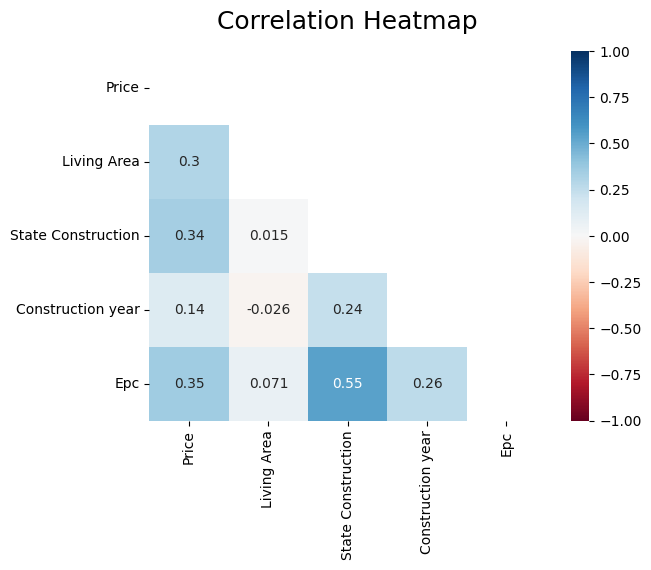

In [375]:

# Creates the heatmap of correlations in matrix form via seaborn

# Creates mask with numeric matrix that will exclude the upper half of the matrix
mask = np.triu(np.ones_like(final_correlation, dtype=bool))

# Creates the heatmap and plots it
heatmap = sns.heatmap(final_correlation, mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdBu')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16)
